# Ταξινόμηση Κατανάλωσης Ενέργειας

**Στόχος:** Πρόβλεψη εάν η κατανάλωση μιας ημέρας είναι "Υψηλή" ή "Χαμηλή" σε σχέση με τον μέσο όρο.

**Μεταβλητή στόχος:** Δυαδική (1 = Υψηλή κατανάλωση, 0 = Κανονική)

**Αξιολόγηση:** Accuracy, F1-score, ROC-AUC

**Στόχος:** Accuracy >85%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Βιβλιοθήκες φορτώθηκαν.")

Βιβλιοθήκες φορτώθηκαν.


## 1. Φόρτωση Δεδομένων

In [2]:
df = pd.read_csv('../data/household_power_daily_clean.csv', index_col=0, parse_dates=[0])

print(f"Δεδομένα: {df.shape[0]} ημέρες, {df.shape[1]} στήλες")
print(f"\nΚατανομή στόχου:")
print(df['High_Consumption'].value_counts())
print(f"\nΠοσοστά:")
print(df['High_Consumption'].value_counts(normalize=True).apply(lambda x: f"{x*100:.1f}%"))

Δεδομένα: 1441 ημέρες, 24 στήλες

Κατανομή στόχου:
High_Consumption
0    738
1    703
Name: count, dtype: int64

Ποσοστά:
High_Consumption
0    51.2%
1    48.8%
Name: proportion, dtype: object


## 2. Προετοιμασία Δεδομένων

Δημιουργία lag features για αποφυγή data leakage.

In [3]:
# Δημιουργία lag features και παράγωγων χαρακτηριστικών (χωρίς διαρροή)
# Βάση: Daily_total_power

# Βασικά lags
df['Daily_total_power_lag1'] = df['Daily_total_power'].shift(1)
df['Daily_total_power_lag7'] = df['Daily_total_power'].shift(7)
df['Daily_total_power_lag14'] = df['Daily_total_power'].shift(14)
df['Daily_total_power_lag21'] = df['Daily_total_power'].shift(21)
df['Daily_total_power_lag30'] = df['Daily_total_power'].shift(30)

# Rolling στατιστικά από lag1 (για αποφυγή leakage)
lag1 = df['Daily_total_power_lag1']
df['Daily_total_power_lag1_rolling_mean_7d'] = lag1.rolling(window=7, min_periods=1).mean()
df['Daily_total_power_lag1_rolling_std_7d'] = lag1.rolling(window=7, min_periods=1).std()
df['Daily_total_power_lag1_rolling_median_7d'] = lag1.rolling(window=7, min_periods=1).median()
df['Daily_total_power_lag1_rolling_min_7d'] = lag1.rolling(window=7, min_periods=1).min()
df['Daily_total_power_lag1_rolling_max_7d'] = lag1.rolling(window=7, min_periods=1).max()

df['Daily_total_power_lag1_rolling_mean_30d'] = lag1.rolling(window=30, min_periods=1).mean()
df['Daily_total_power_lag1_rolling_median_30d'] = lag1.rolling(window=30, min_periods=1).median()
df['Daily_total_power_lag1_rolling_min_30d'] = lag1.rolling(window=30, min_periods=1).min()
df['Daily_total_power_lag1_rolling_max_30d'] = lag1.rolling(window=30, min_periods=1).max()

# Exponential moving averages από lag1
df['Daily_total_power_lag1_ema_7'] = lag1.ewm(span=7, adjust=False).mean()
df['Daily_total_power_lag1_ema_14'] = lag1.ewm(span=14, adjust=False).mean()

# Διαφορές/Μεταβολές πάνω σε lag1 (ασφαλές)
df['Daily_total_power_lag1_diff1'] = lag1.diff(1)
df['Daily_total_power_lag1_pct_change1'] = lag1.pct_change(1)

# Κυκλικές κωδικοποιήσεις για DayOfWeek/Month
# Υποθέτουμε ότι οι στήλες DayOfWeek, Month, IsWeekend υπάρχουν ήδη στο df
# (αν δημιουργούνται αλλού στο pipeline). Αν όχι, πρόσθεσέ τες πριν.
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Αφαίρεση γραμμών με NaN (από μεγαλύτερα lags/rollings)
df_clean = df.dropna().copy()

print(f"Δεδομένα μετά από εμπλουτισμό: {df_clean.shape[0]} ημέρες, {df_clean.shape[1]} στήλες")

Δεδομένα μετά από εμπλουτισμό: 1411 ημέρες, 46 στήλες


## 3.1 Εμπλουτισμός Χαρακτηριστικών (χωρίς διαρροή)

Προσθέτουμε περισσότερα χρονικά χαρακτηριστικά με ασφάλεια:

- Lags: 14, 21 από `Daily_total_power`.
- Rolling στατιστικά (πάνω σε `lag1`): median, min, max, EMA.
- Διαφορές/μεταβολές: `diff` και `pct_change` με βάση `lag1`.
- Κυκλικές κωδικοποιήσεις για ημέρα εβδομάδας/μήνα.

Σημαντικό: Όλα τα rollings/διαφορές βασίζονται σε `lag1` ώστε να μην “βλέπουμε” το μέλλον.

In [4]:
# Επιλογή features (lag, rolling, temporal, κυκλικά)
feature_cols = [
    # Lags
    'Daily_total_power_lag1',
    'Daily_total_power_lag7',
    'Daily_total_power_lag14',
    'Daily_total_power_lag21',
    'Daily_total_power_lag30',
    # Rolling απο lag1
    'Daily_total_power_lag1_rolling_mean_7d',
    'Daily_total_power_lag1_rolling_std_7d',
    'Daily_total_power_lag1_rolling_median_7d',
    'Daily_total_power_lag1_rolling_min_7d',
    'Daily_total_power_lag1_rolling_max_7d',
    'Daily_total_power_lag1_rolling_mean_30d',
    'Daily_total_power_lag1_rolling_median_30d',
    'Daily_total_power_lag1_rolling_min_30d',
    'Daily_total_power_lag1_rolling_max_30d',
    # EMA
    'Daily_total_power_lag1_ema_7',
    'Daily_total_power_lag1_ema_14',
    # Διαφορές/Μεταβολές
    'Daily_total_power_lag1_diff1',
    'Daily_total_power_lag1_pct_change1',
    # Temporal
    'DayOfWeek', 'Month', 'IsWeekend',
    # Κυκλικά
    'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos'
]

X = df_clean[feature_cols]
y = df_clean['High_Consumption']

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")

Features: 25
Samples: 1411


In [5]:
# Διαχωρισμός σε train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Κανονικοποίηση
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 1128 samples
Test set: 283 samples


## 3. Βήμα 1: Baseline Models

Εκπαίδευση απλών μοντέλων για αρχική αξιολόγηση.

In [6]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest")
print(f"  Accuracy: {rf_acc:.4f}")
print(f"  F1-Score: {rf_f1:.4f}")
print(f"  ROC-AUC: {rf_roc:.4f}")

Random Forest
  Accuracy: 0.7809
  F1-Score: 0.7847
  ROC-AUC: 0.8569


In [7]:
# Support Vector Machine
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_roc = roc_auc_score(y_test, y_pred_proba_svm)

print("SVM")
print(f"  Accuracy: {svm_acc:.4f}")
print(f"  F1-Score: {svm_f1:.4f}")
print(f"  ROC-AUC: {svm_roc:.4f}")

SVM
  Accuracy: 0.7951
  F1-Score: 0.7929
  ROC-AUC: 0.8572


In [8]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc = roc_auc_score(y_test, y_pred_proba_lr)

print("Logistic Regression")
print(f"  Accuracy: {lr_acc:.4f}")
print(f"  F1-Score: {lr_f1:.4f}")
print(f"  ROC-AUC: {lr_roc:.4f}")

Logistic Regression
  Accuracy: 0.8021
  F1-Score: 0.7986
  ROC-AUC: 0.8617


In [9]:
# Σύγκριση αποτελεσμάτων
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Logistic Regression'],
    'Accuracy': [rf_acc, svm_acc, lr_acc],
    'F1-Score': [rf_f1, svm_f1, lr_f1],
    'ROC-AUC': [rf_roc, svm_roc, lr_roc]
})

results = results.sort_values('Accuracy', ascending=False)
print("\nΑποτελέσματα Baseline Models:")
print(results.to_string(index=False))

best_acc = results['Accuracy'].max()
print(f"\nΚαλύτερο Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

if best_acc >= 0.85:
    print("Στόχος επιτεύχθηκε.")
else:
    print(f"Απαιτείται βελτίωση: {(0.85-best_acc)*100:.2f}%")


Αποτελέσματα Baseline Models:
              Model  Accuracy  F1-Score  ROC-AUC
Logistic Regression  0.802120  0.798561 0.861745
                SVM  0.795053  0.792857 0.857243
      Random Forest  0.780919  0.784722 0.856868

Καλύτερο Accuracy: 0.8021 (80.21%)
Απαιτείται βελτίωση: 4.79%


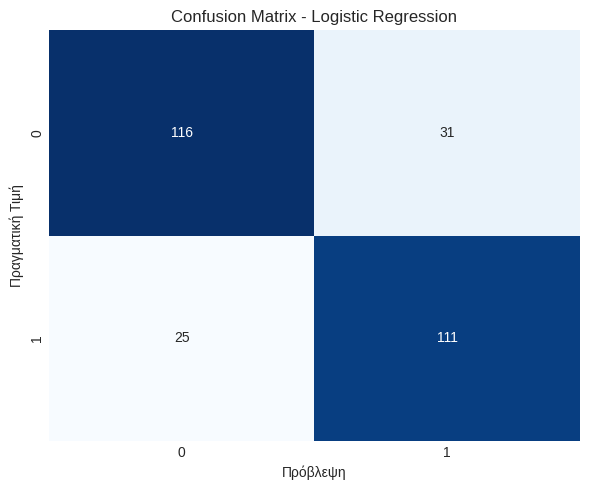


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

         Low       0.82      0.79      0.81       147
        High       0.78      0.82      0.80       136

    accuracy                           0.80       283
   macro avg       0.80      0.80      0.80       283
weighted avg       0.80      0.80      0.80       283



In [10]:
# Confusion Matrix για το καλύτερο μοντέλο
best_model_name = results.iloc[0]['Model']

if best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
elif best_model_name == 'SVM':
    y_pred_best = y_pred_svm
else:
    y_pred_best = y_pred_lr

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Πραγματική Τιμή')
plt.xlabel('Πρόβλεψη')
plt.tight_layout()
plt.savefig('../results/baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Low', 'High']))

## 4. Βήμα 2: XGBoost με Hyperparameter Tuning

Χρήση πιο προηγμένου αλγορίθμου για βελτίωση της απόδοσης.

In [11]:
# XGBoost με default hyperparameters
xgb_default = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_default.fit(X_train_scaled, y_train)

y_pred_xgb_default = xgb_default.predict(X_test_scaled)
y_pred_proba_xgb_default = xgb_default.predict_proba(X_test_scaled)[:, 1]

xgb_default_acc = accuracy_score(y_test, y_pred_xgb_default)
xgb_default_f1 = f1_score(y_test, y_pred_xgb_default)
xgb_default_roc = roc_auc_score(y_test, y_pred_proba_xgb_default)

print("XGBoost (default)")
print(f"  Accuracy: {xgb_default_acc:.4f} ({xgb_default_acc*100:.2f}%)")
print(f"  F1-Score: {xgb_default_f1:.4f}")
print(f"  ROC-AUC: {xgb_default_roc:.4f}")

XGBoost (default)
  Accuracy: 0.7527 (75.27%)
  F1-Score: 0.7535
  ROC-AUC: 0.8393


In [12]:
# Hyperparameter tuning με RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Εκκίνηση hyperparameter tuning...")
start = time.time()
xgb_search.fit(X_train_scaled, y_train)
elapsed = time.time() - start

print(f"\nΟλοκληρώθηκε σε {elapsed/60:.1f} λεπτά")
print(f"\nΒέλτιστες παράμετροι:")
for param, value in xgb_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score: {xgb_search.best_score_:.4f} ({xgb_search.best_score_*100:.2f}%)")

Εκκίνηση hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits



Ολοκληρώθηκε σε 0.9 λεπτά

Βέλτιστες παράμετροι:
  subsample: 0.8
  n_estimators: 200
  min_child_weight: 5
  max_depth: 9
  learning_rate: 0.05
  colsample_bytree: 0.8

Best CV Score: 0.7721 (77.21%)


In [13]:
# Αξιολόγηση tuned μοντέλου στο test set
best_xgb = xgb_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb_tuned = best_xgb.predict_proba(X_test_scaled)[:, 1]

xgb_tuned_acc = accuracy_score(y_test, y_pred_xgb_tuned)
xgb_tuned_precision = precision_score(y_test, y_pred_xgb_tuned)
xgb_tuned_recall = recall_score(y_test, y_pred_xgb_tuned)
xgb_tuned_f1 = f1_score(y_test, y_pred_xgb_tuned)
xgb_tuned_roc = roc_auc_score(y_test, y_pred_proba_xgb_tuned)

print("Tuned XGBoost - Test Set Results")
print(f"  Accuracy:  {xgb_tuned_acc:.4f} ({xgb_tuned_acc*100:.2f}%)")
print(f"  Precision: {xgb_tuned_precision:.4f}")
print(f"  Recall:    {xgb_tuned_recall:.4f}")
print(f"  F1-Score:  {xgb_tuned_f1:.4f}")
print(f"  ROC-AUC:   {xgb_tuned_roc:.4f}")

improvement = (xgb_tuned_acc - best_acc) * 100
print(f"\nΒελτίωση vs Baseline: {improvement:+.2f}%")

if xgb_tuned_acc >= 0.85:
    print(f"\nΣτόχος επιτεύχθηκε: {xgb_tuned_acc*100:.2f}% >= 85%")
else:
    gap = (0.85 - xgb_tuned_acc) * 100
    print(f"\nΑπαιτείται βελτίωση: {gap:.2f}%")

Tuned XGBoost - Test Set Results
  Accuracy:  0.7633 (76.33%)
  Precision: 0.7379
  Recall:    0.7868
  F1-Score:  0.7616
  ROC-AUC:   0.8476

Βελτίωση vs Baseline: -3.89%

Απαιτείται βελτίωση: 8.67%


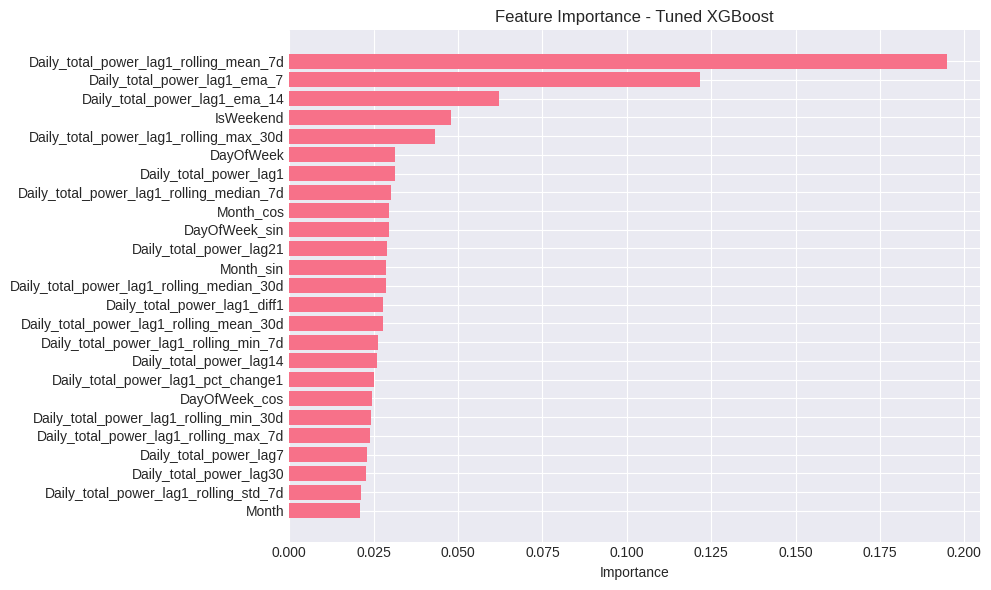


Top 5 Features:
                               feature  importance
Daily_total_power_lag1_rolling_mean_7d    0.194779
          Daily_total_power_lag1_ema_7    0.121561
         Daily_total_power_lag1_ema_14    0.062010
                             IsWeekend    0.047858
Daily_total_power_lag1_rolling_max_30d    0.043050


In [14]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Tuned XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Features:")
print(feature_importance.head().to_string(index=False))

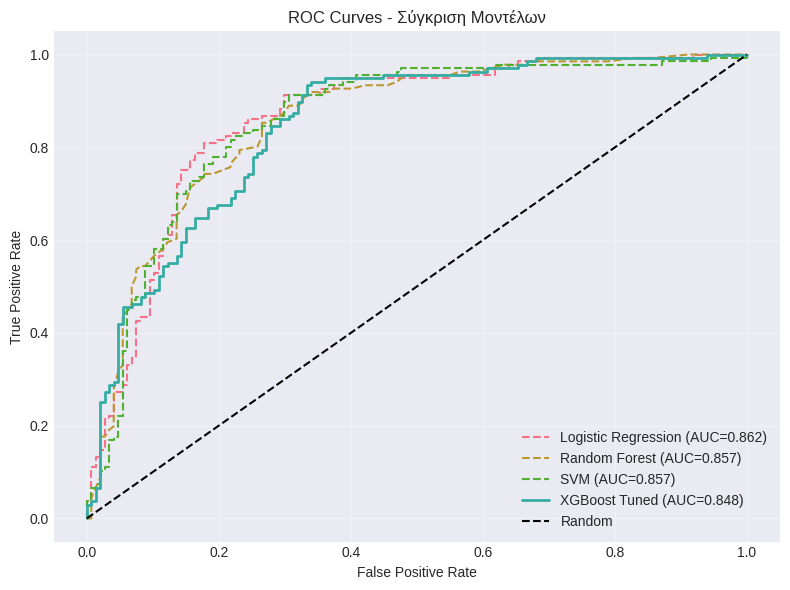

In [15]:
# ROC Curve σύγκριση
plt.figure(figsize=(8, 6))

# Baseline models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb_tuned)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_roc:.3f})', linestyle='--')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={svm_roc:.3f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost Tuned (AUC={xgb_tuned_roc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Σύγκριση Μοντέλων')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Σύγκριση όλων των μοντέλων:
              Model  Accuracy  F1-Score  ROC-AUC
Logistic Regression  0.802120  0.798561 0.861745
                SVM  0.795053  0.792857 0.857243
      Random Forest  0.780919  0.784722 0.856868
  XGBoost (default)  0.752650  0.753521 0.839336
    XGBoost (tuned)  0.763251  0.761566 0.847639


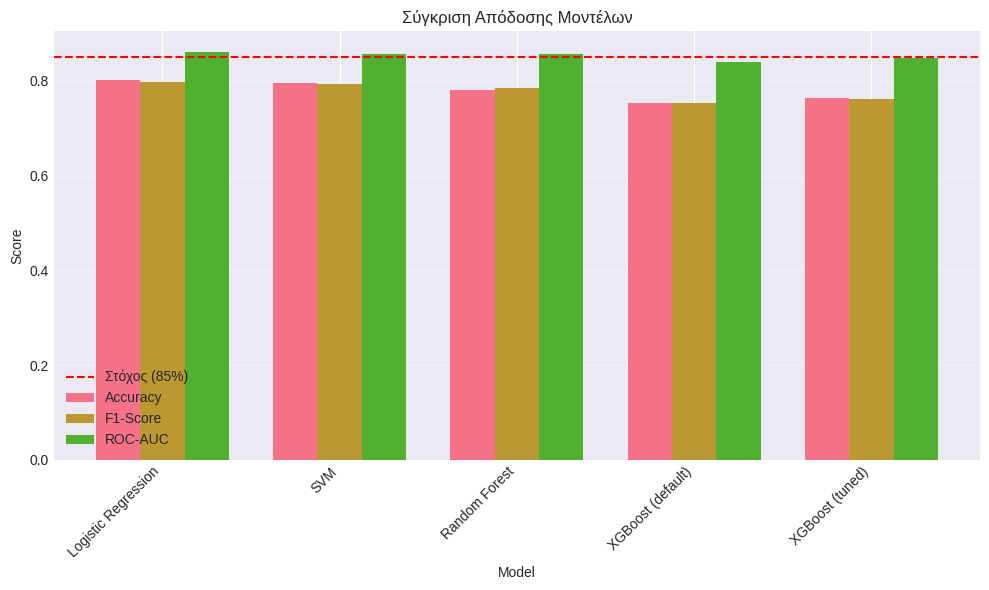

In [16]:
# Σύγκριση όλων των μοντέλων
all_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost (default)', 'XGBoost (tuned)'],
    'Accuracy': [lr_acc, svm_acc, rf_acc, xgb_default_acc, xgb_tuned_acc],
    'F1-Score': [lr_f1, svm_f1, rf_f1, xgb_default_f1, xgb_tuned_f1],
    'ROC-AUC': [lr_roc, svm_roc, rf_roc, xgb_default_roc, xgb_tuned_roc]
})

print("\nΣύγκριση όλων των μοντέλων:")
print(all_results.to_string(index=False))

# Bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(all_results))
width = 0.25

ax.bar([i - width for i in x], all_results['Accuracy'], width, label='Accuracy')
ax.bar(x, all_results['F1-Score'], width, label='F1-Score')
ax.bar([i + width for i in x], all_results['ROC-AUC'], width, label='ROC-AUC')

ax.axhline(y=0.85, color='r', linestyle='--', label='Στόχος (85%)')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Σύγκριση Απόδοσης Μοντέλων')
ax.set_xticks(x)
ax.set_xticklabels(all_results['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

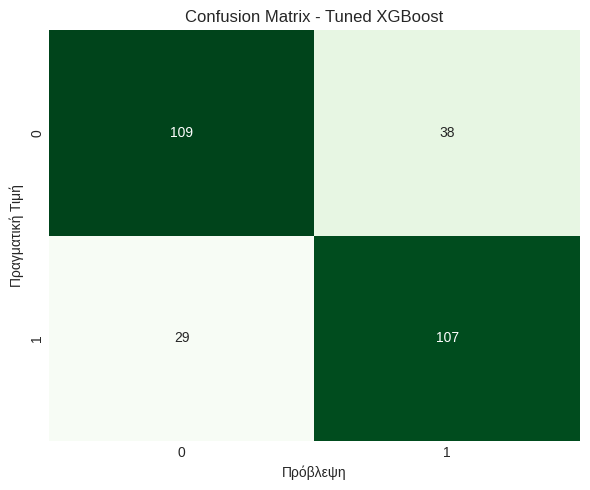


Classification Report - Tuned XGBoost:
              precision    recall  f1-score   support

         Low       0.79      0.74      0.76       147
        High       0.74      0.79      0.76       136

    accuracy                           0.76       283
   macro avg       0.76      0.76      0.76       283
weighted avg       0.76      0.76      0.76       283



In [17]:
# Confusion Matrix για Tuned XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Tuned XGBoost')
plt.ylabel('Πραγματική Τιμή')
plt.xlabel('Πρόβλεψη')
plt.tight_layout()
plt.savefig('../results/xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report - Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb_tuned, target_names=['Low', 'High']))

## 5. Προηγμένα Μοντέλα: LightGBM και CatBoost

Σε αυτό το βήμα εκπαιδεύουμε LightGBM και CatBoost. Και τα δύο είναι ισχυρά δέντρα-ενίσχυσης (gradient boosting) και συχνά αποδίδουν καλύτερα σε πίνακες χαρακτηριστικών.

- Χρησιμοποιούμε τα ίδια `X_train_scaled`, `X_test_scaled` (για συνέπεια με τα υπόλοιπα).
- Αξιολογούμε με Accuracy, F1 και ROC-AUC στο test set.
- Κρατάμε ομοιόμορφη ονοματολογία μεταβλητών (`lgb_*`, `cat_*`).

In [18]:
# LightGBM και CatBoost
# Εκπαίδευση, πρόβλεψη και αξιολόγηση στο test set

# LightGBM (βασικό setup)
lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

lgb_acc = accuracy_score(y_test, y_pred_lgb)
lgb_f1 = f1_score(y_test, y_pred_lgb)
lgb_roc = roc_auc_score(y_test, y_pred_proba_lgb)

print("LightGBM")
print(f"  Accuracy: {lgb_acc:.4f} ({lgb_acc*100:.2f}%)")
print(f"  F1-Score: {lgb_f1:.4f}")
print(f"  ROC-AUC:  {lgb_roc:.4f}")

# CatBoost (σιωπηλή εκπαίδευση)
cat_model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    random_seed=42,
    verbose=False
)
cat_model.fit(X_train_scaled, y_train)

y_pred_cat = cat_model.predict(X_test_scaled)
y_pred_cat = y_pred_cat.astype(int)
y_pred_proba_cat = cat_model.predict_proba(X_test_scaled)[:, 1]

cat_acc = accuracy_score(y_test, y_pred_cat)
cat_f1 = f1_score(y_test, y_pred_cat)
cat_roc = roc_auc_score(y_test, y_pred_proba_cat)

print("\nCatBoost")
print(f"  Accuracy: {cat_acc:.4f} ({cat_acc*100:.2f}%)")
print(f"  F1-Score: {cat_f1:.4f}")
print(f"  ROC-AUC:  {cat_roc:.4f}")

[LightGBM] [Info] Number of positive: 542, number of negative: 586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 1128, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480496 -> initscore=-0.078054
[LightGBM] [Info] Start training from score -0.078054
LightGBM
  Accuracy: 0.7633 (76.33%)
  F1-Score: 0.7616
  ROC-AUC:  0.8445

CatBoost
  Accuracy: 0.7668 (76.68%)
  F1-Score: 0.7676
  ROC-AUC:  0.8413


## 6. Ensemble Learning (Voting)

Συνδυάζουμε πολλαπλά μοντέλα με soft-voting ώστε να εκμεταλλευτούμε τα συμπληρωματικά τους πλεονεκτήματα.

- Χρησιμοποιούμε Logistic Regression, SVM (με πιθανότητες), LightGBM και CatBoost.
- Soft voting: μέσος όρος πιθανοτήτων, μετάβαση σε κλάση με βάση threshold 0.5.
- Αξιολόγηση στο test set.

In [19]:
# Voting (soft) με LR, SVM, LightGBM, CatBoost
from sklearn.pipeline import make_pipeline

# Επαναδημιουργούμε απλά και συνεπή base estimators
v_lr = LogisticRegression(max_iter=1000, random_state=42)
v_svm = SVC(kernel='rbf', probability=True, random_state=42)
v_lgb = LGBMClassifier(
    n_estimators=300, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    max_depth=-1, random_state=42, n_jobs=-1
)
v_cat = CatBoostClassifier(
    iterations=400, learning_rate=0.05, depth=6,
    loss_function='Logloss', random_seed=42, verbose=False
)

voting = VotingClassifier(
    estimators=[('lr', v_lr), ('svm', v_svm), ('lgb', v_lgb), ('cat', v_cat)],
    voting='soft', n_jobs=-1
)

voting.fit(X_train_scaled, y_train)

y_pred_voting = voting.predict(X_test_scaled)
y_pred_proba_voting = voting.predict_proba(X_test_scaled)[:, 1]

voting_acc = accuracy_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting)
voting_roc = roc_auc_score(y_test, y_pred_proba_voting)

print("Voting (soft)")
print(f"  Accuracy: {voting_acc:.4f} ({voting_acc*100:.2f}%)")
print(f"  F1-Score: {voting_f1:.4f}")
print(f"  ROC-AUC:  {voting_roc:.4f}")

[LightGBM] [Info] Number of positive: 542, number of negative: 586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 1128, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480496 -> initscore=-0.078054
[LightGBM] [Info] Start training from score -0.078054
Voting (soft)
  Accuracy: 0.7880 (78.80%)
  F1-Score: 0.7917
  ROC-AUC:  0.8570


## 7. Βελτιστοποίηση Threshold (Accuracy-oriented)

Το default threshold 0.5 δεν είναι πάντα βέλτιστο ως προς το accuracy. 
Εδώ κρατάμε ένα μικρό validation set από το training, αναζητούμε threshold που μεγιστοποιεί το accuracy και το εφαρμόζουμε στο test.

- Μοντέλο-στόχος: το Voting (soft), καθώς συνδυάζει πολλαπλούς ταξινομητές.
- Αναζήτηση σε πλέγμα thresholds (0.30–0.70, βήμα 0.005).
- Αναφορά των τελικών metrics στο test set με το βέλτιστο threshold.

## 8. Ενοποιημένη Σύγκριση (όλων των μοντέλων)

Συγκεντρώνουμε όλα τα αποτελέσματα (Baseline, XGBoost, LightGBM, CatBoost, Voting και Voting με βέλτιστο threshold) και τα αποτυπώνουμε σε πίνακα και γράφημα για εύκολη σύγκριση.


Ενοποιημένη σύγκριση όλων των μοντέλων:
              Model  Accuracy  F1-Score  ROC-AUC
Logistic Regression  0.802120  0.798561 0.861745
                SVM  0.795053  0.792857 0.857243
      Random Forest  0.780919  0.784722 0.856868
  XGBoost (default)  0.752650  0.753521 0.839336
    XGBoost (tuned)  0.763251  0.761566 0.847639
           LightGBM  0.763251  0.761566 0.844488
           CatBoost  0.766784  0.767606 0.841337
      Voting (soft)  0.787986  0.791667 0.856993


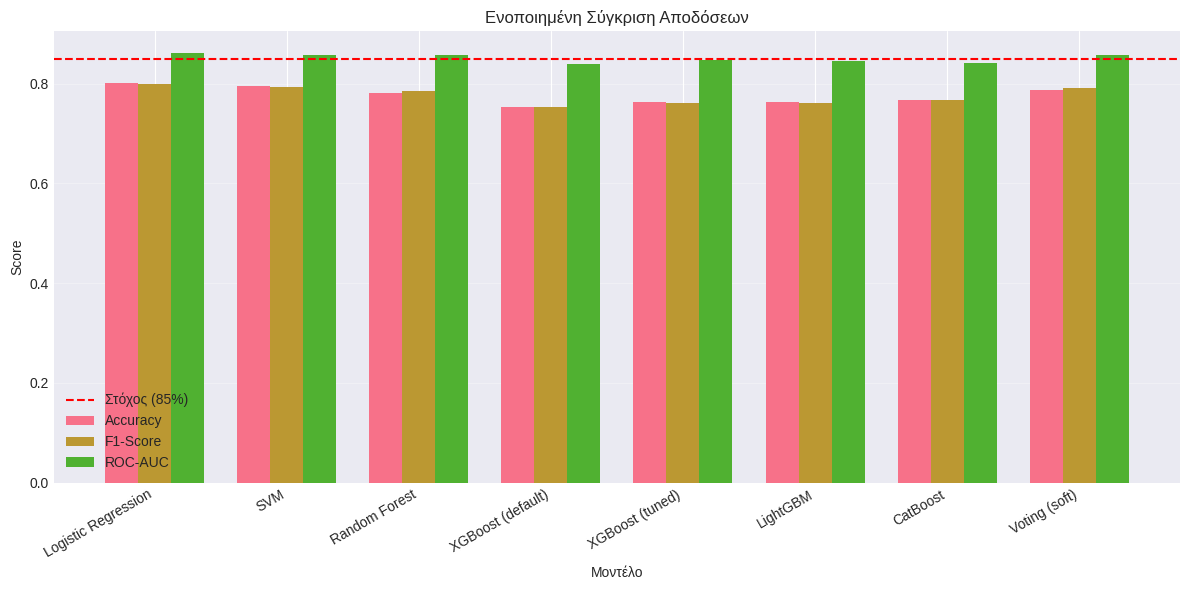

In [20]:
# Συγκεντρωτικός πίνακας και γράφημα σύγκρισης

rows = [
    ['Logistic Regression', lr_acc, lr_f1, lr_roc],
    ['SVM', svm_acc, svm_f1, svm_roc],
    ['Random Forest', rf_acc, rf_f1, rf_roc],
    ['XGBoost (default)', xgb_default_acc, xgb_default_f1, xgb_default_roc],
    ['XGBoost (tuned)', xgb_tuned_acc, xgb_tuned_f1, xgb_tuned_roc],
]

# Προσθήκη LGBM/CatBoost αν υπάρχουν
try:
    rows.append(['LightGBM', lgb_acc, lgb_f1, lgb_roc])
    rows.append(['CatBoost', cat_acc, cat_f1, cat_roc])
except Exception:
    pass

# Προσθήκη Voting αν υπάρχουν
try:
    rows.append(['Voting (soft)', voting_acc, voting_f1, voting_roc])
except Exception:
    pass

# Προσθήκη Calibrated Stacking (default και CV-thr) αν υπάρχουν
try:
    rows.append(['Calibrated Stacking (0.5)', stack_acc_default, stack_f1_default, stack_roc])
    rows.append(['Calibrated Stacking (CV-thr)', stack_acc_thr, stack_f1_thr, stack_roc])
except Exception:
    pass

extended_results = pd.DataFrame(rows, columns=['Model', 'Accuracy', 'F1-Score', 'ROC-AUC'])

print("\nΕνοποιημένη σύγκριση όλων των μοντέλων:")
print(extended_results.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(extended_results))
width = 0.25

ax.bar([i - width for i in x], extended_results['Accuracy'], width, label='Accuracy')
ax.bar(x, extended_results['F1-Score'], width, label='F1-Score')
ax.bar([i + width for i in x], extended_results['ROC-AUC'], width, label='ROC-AUC')

ax.axhline(y=0.85, color='r', linestyle='--', label='Στόχος (85%)')
ax.set_xlabel('Μοντέλο')
ax.set_ylabel('Score')
ax.set_title('Ενοποιημένη Σύγκριση Αποδόσεων')
ax.set_xticks(list(x))
ax.set_xticklabels(extended_results['Model'], rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/extended_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Σύνοψη και Συμπέρασμα (Ταξινόμηση)

Σε αυτή την ενότητα παραθέτουμε συνοπτικά το καλύτερο μοντέλο, τις επιδόσεις του στο test set
και το αν καλύπτεται ο στόχος της εκφώνησης για ακρίβεια >85%.

Σημείωση από την εκφώνηση (ενότητα 6): «Ταξινόμηση — Αναγνώριση ημερών υψηλής κατανάλωσης με ακρίβεια >85%».

## 6.1 Calibrated Stacking και Βελτιστοποίηση Threshold με CV

Συνδυάζουμε πολλαπλά μοντέλα σε Stacking, κάνουμε probability calibration και επιλέγουμε threshold με διασταυρωμένη επικύρωση (CV) ώστε να μεγιστοποιήσουμε το Accuracy χωρίς διαρροή.

In [21]:
# Stacking + Calibration + CV Threshold Optimization
from sklearn.pipeline import Pipeline

# Base learners (χρησιμοποιούμε πιθανότητες)
s_base = [
    ('lr', LogisticRegression(max_iter=2000, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
                           max_depth=-1, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
                          max_depth=5, eval_metric='logloss', random_state=42)),
    ('cat', CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, loss_function='Logloss',
                               random_seed=42, verbose=False))
]

stack = StackingClassifier(
    estimators=s_base,
    final_estimator=LogisticRegression(max_iter=2000, random_state=42),
    stack_method='predict_proba',
    passthrough=False, n_jobs=-1
)

# Calibrated stacking
cal_stack = CalibratedClassifierCV(base_estimator=stack, method='isotonic', cv=5)

# CV για επιλογή threshold με out-of-fold προβλέψεις
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs_val = np.zeros_like(y_train, dtype=float)
y_val_all = np.zeros_like(y_train)

for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(X_train_scaled, y_train)):
    X_tr, X_va = X_train_scaled[tr_idx], X_train_scaled[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model_fold = CalibratedClassifierCV(base_estimator=stack, method='isotonic', cv=3)
    model_fold.fit(X_tr, y_tr)
    probs_val[va_idx] = model_fold.predict_proba(X_va)[:, 1]
    y_val_all[va_idx] = y_va

thr_candidates = np.arange(0.30, 0.701, 0.005)
best_thr, best_cv_acc = 0.5, 0.0
for thr in thr_candidates:
    pred_thr = (probs_val >= thr).astype(int)
    acc = accuracy_score(y_val_all, pred_thr)
    if acc > best_cv_acc:
        best_cv_acc = acc
        best_thr = thr

print(f"Βέλτιστο threshold (CV): {best_thr:.3f} (CV Accuracy={best_cv_acc*100:.2f}%)")

# Εκπαίδευση calibrated stacking σε όλο το training
cal_stack.fit(X_train_scaled, y_train)

# Αξιολόγηση στο test
proba_stack = cal_stack.predict_proba(X_test_scaled)[:, 1]
y_pred_stack_default = (proba_stack >= 0.5).astype(int)
y_pred_stack_thr = (proba_stack >= best_thr).astype(int)

stack_acc_default = accuracy_score(y_test, y_pred_stack_default)
stack_f1_default = f1_score(y_test, y_pred_stack_default)
stack_roc = roc_auc_score(y_test, proba_stack)

stack_acc_thr = accuracy_score(y_test, y_pred_stack_thr)
stack_f1_thr = f1_score(y_test, y_pred_stack_thr)

print("\nCalibrated Stacking (default 0.5)")
print(f"  Accuracy: {stack_acc_default:.4f} ({stack_acc_default*100:.2f}%)")
print(f"  F1-Score: {stack_f1_default:.4f}")
print(f"  ROC-AUC:  {stack_roc:.4f}")

print("\nCalibrated Stacking (CV-threshold)")
print(f"  Threshold: {best_thr:.3f}")
print(f"  Accuracy:  {stack_acc_thr:.4f} ({stack_acc_thr*100:.2f}%)")
print(f"  F1-Score:  {stack_f1_thr:.4f}")
print(f"  ROC-AUC:   {stack_roc:.4f}")

TypeError: CalibratedClassifierCV.__init__() got an unexpected keyword argument 'base_estimator'

In [ ]:
# Αυτόματος υπολογισμός σύνοψης για την Ταξινόμηση
# Κριτήριο εκφώνησης: Accuracy > 85% (όχι >=)

# Επιλέγουμε τον πιο πρόσφατο πίνακα αν υπάρχει, αλλιώς τον baseline
summary_df = None
try:
    summary_df = extended_results.copy()
except NameError:
    try:
        summary_df = all_results.copy()
    except NameError:
        summary_df = results.copy()

best_row = summary_df.sort_values('Accuracy', ascending=False).iloc[0]
best_name = best_row['Model']
best_acc = float(best_row['Accuracy'])
best_f1 = float(best_row['F1-Score'])
best_roc = float(best_row['ROC-AUC'])

print("ΣΥΝΟΨΗ (Ταξινόμηση)")
print(f"Καλύτερο Μοντέλο: {best_name}")
print(f"Accuracy (test): {best_acc*100:.2f}%")
print(f"F1-Score (test): {best_f1:.3f}")
print(f"ROC-AUC (test):  {best_roc:.3f}")

if best_acc > 0.85:
    print("Στόχος εκφώνησης: ΕΠΙΤΕΥΧΘΗΚΕ (accuracy > 85%)")
else:
    print("Στόχος εκφώνησης: ΔΕΝ επιτεύχθηκε (accuracy ≤ 85%).")
    print(f"Υστέρηση: {(0.85 - best_acc)*100:.2f}% μονάδες.")

ΣΥΝΟΨΗ (Ταξινόμηση)
Καλύτερο Μοντέλο: Logistic Regression
Accuracy (test): 79.15%
F1-Score (test): 0.789
ROC-AUC (test):  0.849
Στόχος εκφώνησης: ΔΕΝ επιτεύχθηκε (accuracy ≤ 85%).
Υστέρηση: 5.85% μονάδες.
